# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

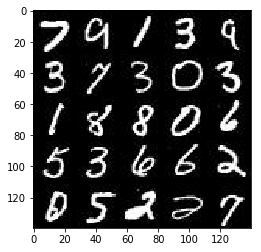

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

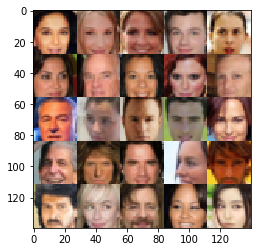

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input: 28x28x3
    
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x{out_channel_dim}
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * 0.9    # label smoothing
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4499... Generator Loss: 4.4052
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 3.5329... Generator Loss: 0.0666
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 5.6301
Epoch 1/2... Discriminator Loss: 0.5363... Generator Loss: 2.7050
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 0.9032
Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 1.2733
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 2.5474
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 3.5061
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 4.6502


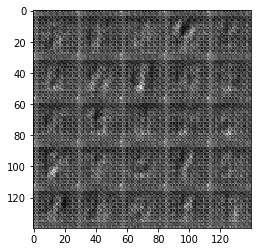

Epoch 1/2... Discriminator Loss: 0.5532... Generator Loss: 3.0897
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.5185
Epoch 1/2... Discriminator Loss: 2.1638... Generator Loss: 5.2735
Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 2.8485
Epoch 1/2... Discriminator Loss: 0.7024... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 0.7530... Generator Loss: 2.2820
Epoch 1/2... Discriminator Loss: 0.5930... Generator Loss: 1.9834
Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 2.1142
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 0.9951


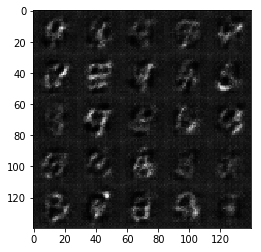

Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 1.8127
Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 1.7566
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 1.7380
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 2.5859
Epoch 1/2... Discriminator Loss: 0.6851... Generator Loss: 1.3783
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 2.9456
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 3.6997
Epoch 1/2... Discriminator Loss: 0.5954... Generator Loss: 1.8509
Epoch 1/2... Discriminator Loss: 0.6032... Generator Loss: 1.8363


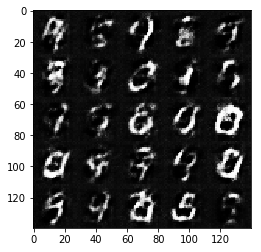

Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.3879
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.7680
Epoch 1/2... Discriminator Loss: 0.6403... Generator Loss: 1.6392
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 0.6833... Generator Loss: 1.5404
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.7885
Epoch 1/2... Discriminator Loss: 0.5117... Generator Loss: 2.3846
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 2.9188
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 1.6564


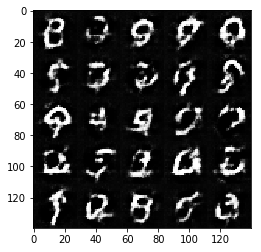

Epoch 1/2... Discriminator Loss: 0.6080... Generator Loss: 2.1588
Epoch 1/2... Discriminator Loss: 0.7321... Generator Loss: 2.6511
Epoch 1/2... Discriminator Loss: 0.6118... Generator Loss: 1.7045
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 0.7677... Generator Loss: 2.7845
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 1.4227
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 2.0801
Epoch 1/2... Discriminator Loss: 0.6462... Generator Loss: 2.0474
Epoch 1/2... Discriminator Loss: 0.5875... Generator Loss: 1.7604
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 2.3922


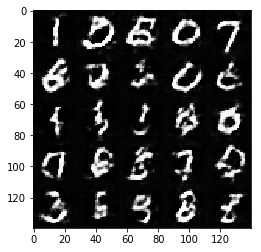

Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 2.1302
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 1.6795
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 2.2587
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 1.5092
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.7474
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.8658
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 4.0831
Epoch 1/2... Discriminator Loss: 0.6330... Generator Loss: 1.8650


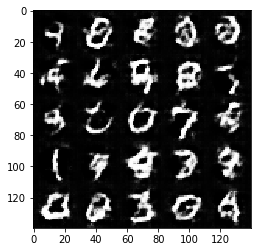

Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 1.6538
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 1.3950
Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 0.7091... Generator Loss: 1.3873
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 1.7348
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 1.5347
Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 2.0129


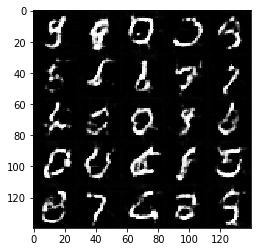

Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.2384
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 0.6695... Generator Loss: 1.5681
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.6783
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.6039
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 0.6123... Generator Loss: 1.9948
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 0.9155


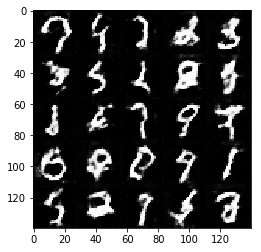

Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 2.0838
Epoch 1/2... Discriminator Loss: 0.6684... Generator Loss: 1.6048
Epoch 1/2... Discriminator Loss: 0.7130... Generator Loss: 1.4746
Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 1.3007
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.4792
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.2412
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.2761


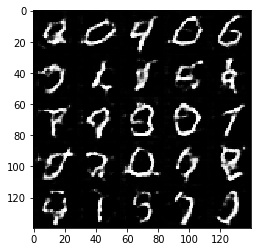

Epoch 1/2... Discriminator Loss: 0.7521... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 0.6586... Generator Loss: 1.5054
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 1.3083
Epoch 2/2... Discriminator Loss: 2.2087... Generator Loss: 0.2472
Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.0273
Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.7266
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 1.5688
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 1.4230
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.8330


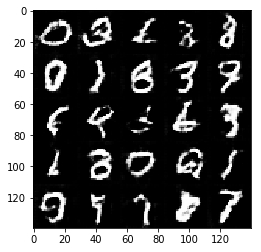

Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 1.4301
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.6772
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.7570
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.5118
Epoch 2/2... Discriminator Loss: 2.2188... Generator Loss: 0.2546
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 0.6479... Generator Loss: 1.7606
Epoch 2/2... Discriminator Loss: 0.6729... Generator Loss: 1.5915
Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.4641


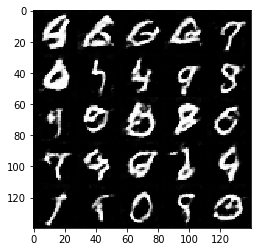

Epoch 2/2... Discriminator Loss: 1.9621... Generator Loss: 3.8806
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 1.3558
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 2.3640
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.9471
Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.2137
Epoch 2/2... Discriminator Loss: 0.7511... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 2.0166


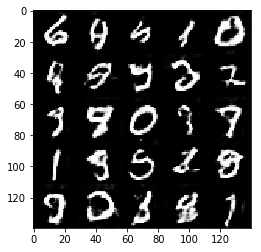

Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 3.5598
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.3227
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 0.7611... Generator Loss: 1.2870
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.2564
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 2.0390
Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.1555
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.6512


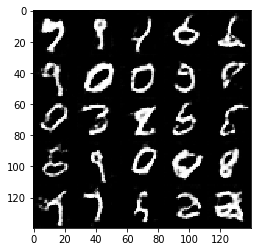

Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 1.7448
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.5021
Epoch 2/2... Discriminator Loss: 1.9471... Generator Loss: 4.1810
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.6661
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.2799
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.6174
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.0321


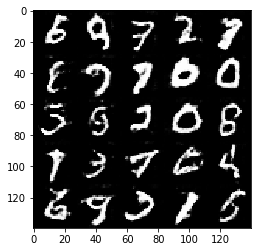

Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 1.6249
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.6812
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.6666
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.7924
Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 1.6147
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 2.4767
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 1.0424


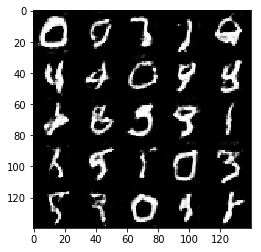

Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.1639
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.4784
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 1.0459
Epoch 2/2... Discriminator Loss: 0.6726... Generator Loss: 1.5622
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 1.7086
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 2.1019
Epoch 2/2... Discriminator Loss: 1.1111... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 0.8675


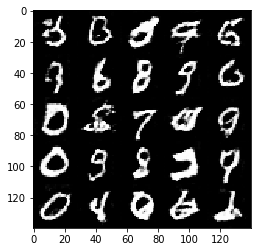

Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.5315
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.3908
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.8464
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.2855
Epoch 2/2... Discriminator Loss: 0.6221... Generator Loss: 1.9216
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.4901
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.7799
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 1.9877... Generator Loss: 3.4316


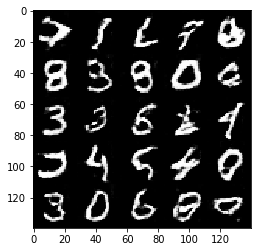

Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.0984
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.4749
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.9162
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 1.6386
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 2.5770
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.2425
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 2.2116
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.7118


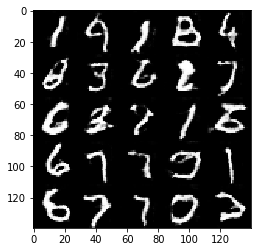

Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 1.1927
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.1611
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.3978


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 4.6501
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 2.1454
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 5.7232
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 3.3091
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 3.2520
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.9372


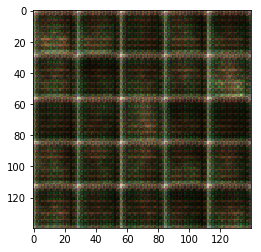

Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 5.8550
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 3.2150
Epoch 1/1... Discriminator Loss: 0.5537... Generator Loss: 2.4512
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 3.8801
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 2.3985
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 2.3178
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7167


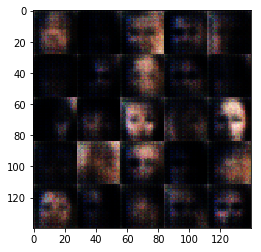

Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 2.6960
Epoch 1/1... Discriminator Loss: 0.6175... Generator Loss: 1.9571
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 2.2957
Epoch 1/1... Discriminator Loss: 0.6286... Generator Loss: 1.7940
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 3.0426
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.7474
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.6379
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 2.0593


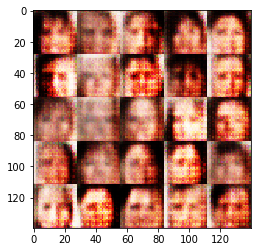

Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 2.7370
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 2.4009
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.8387


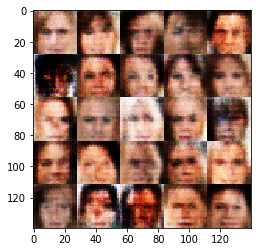

Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.7128
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.5854
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.5040
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 4.4519


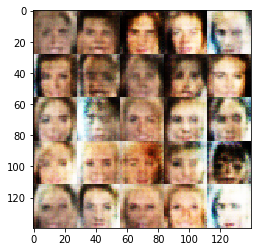

Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 2.2253
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.8869
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.6714... Generator Loss: 3.6451
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 2.7635


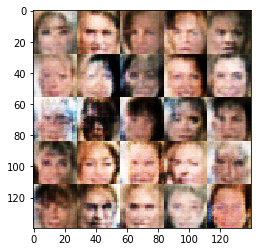

Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.6518
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.9509
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 2.0110
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.9086
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.8934


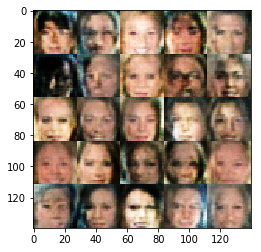

Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.5730
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 2.9397
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.9855
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.8048


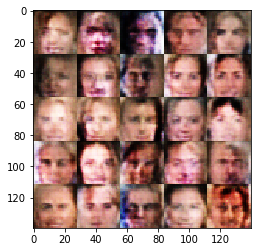

Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.5258
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.6545
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 2.0589
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.3391
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 2.4005
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.4105


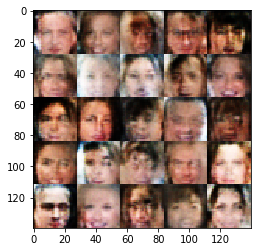

Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 2.6142
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.6572
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.8871


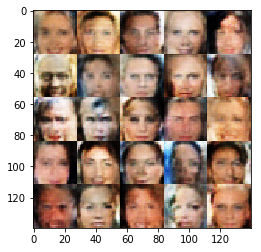

Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.7525
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.6004
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 2.4129
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.1680


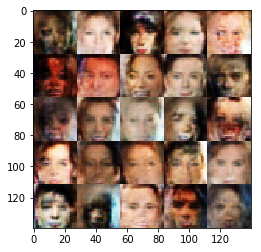

Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.8854
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.8052
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 3.5130
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.9718
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 2.8005
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.7608


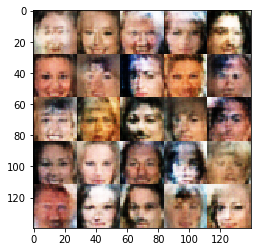

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 3.2850
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.3848
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.3659


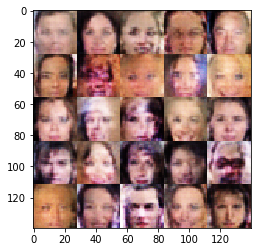

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 2.0703
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.4638


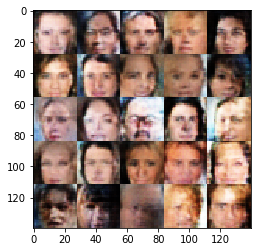

Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.7021
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.6665... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.1437
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 2.5004
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.8185


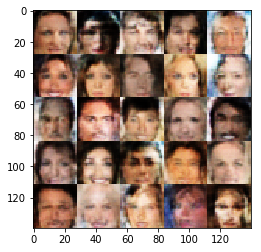

Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.4497
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.9407
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 2.2803
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.6697
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.8450


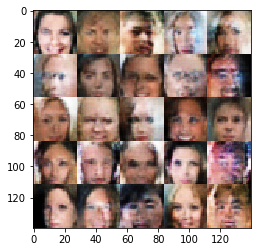

Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.6168
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.6957
Epoch 1/1... Discriminator Loss: 1.7666... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.8396
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6333


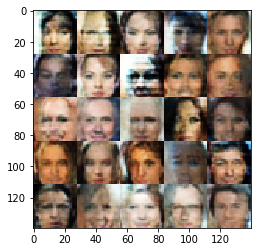

Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.3541
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 2.5320


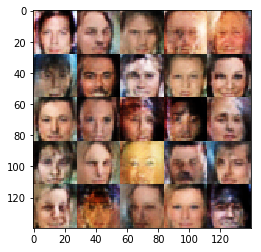

Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 2.0417
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 2.0343
Epoch 1/1... Discriminator Loss: 0.6716... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.7298


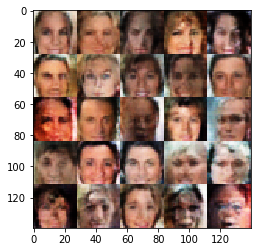

Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.8492
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.8421
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0847


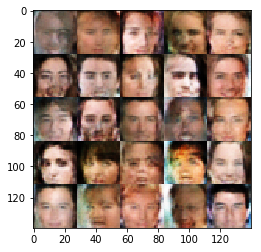

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.4814


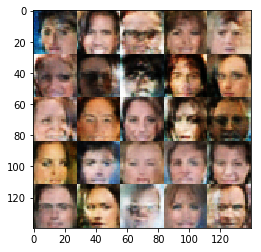

Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 1.8316
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.7507
Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.4078


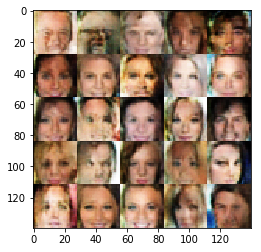

Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.6862
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.6950


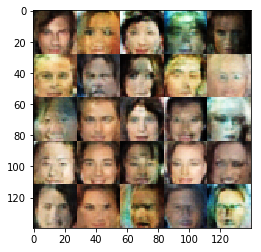

Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 2.0186
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.5822
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 2.0779
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 2.3850
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.6344
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.3794


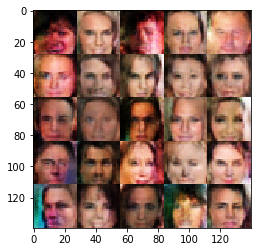

Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 2.1590
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 2.1283
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.3106


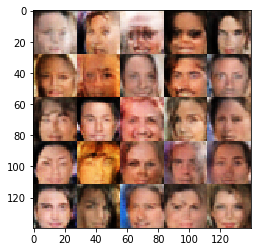

Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.9606
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.1278


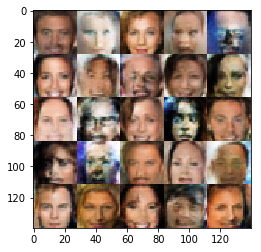

Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.5032
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 2.3827
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.8292


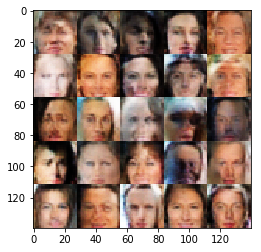

Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.4283
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 2.4007
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.6277


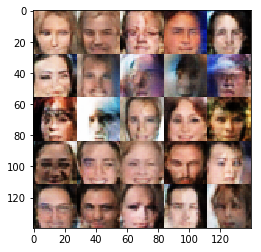

Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.5120
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 2.1400
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.0005
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.3471


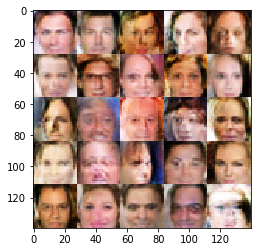

Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.1181
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.7854
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.3937
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.9640
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.5998


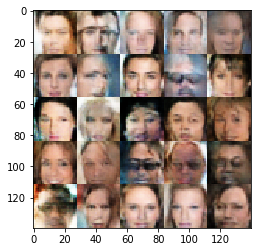

Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.6373
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.6168... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.1444


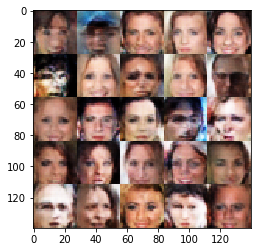

Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.3904


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.